# KMEANS comparison

- Make sure to select a ML cluster



### Dependencies


In [0]:

import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import udf, when, col
from pyspark.sql.types import DoubleType
from pyspark.ml.clustering import KMeans
from pyspark.sql import functions as F

from scipy.spatial.distance import cdist

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

import mlflow

## Import Data

Retrieving a file with a subset of the data displaying it in a pyspark df

In [0]:
file_location = "/FileStore/tables/proceessed/part-00000-tid-7216056373568144993-71829a2c-6d1e-4bc4-867b-e7304ed9bfd4-880-1-c000.snappy.parquet"

file_type = "parquet"

df = spark.read.format(file_type) \
.load(file_location)

df.display()

passenger_count trip_distance PULocationID DOLocationID payment_type fare_amount extra tip_amount total_amount congestion_surcharge time_diff_minutes day_of_week 1.0 0.41 24.0 24.0 1.0 4.0 0.5 1.06 6.36 0.0 2.783 5 1.0 0.41 43.0 43.0 2.0 3.5 0.5 0.0 4.8 0.0 1.033 6 1.0 0.4 24.0 24.0 1.0 4.0 0.5 5.0 10.3 0.0 2.683 6 1.0 0.27 43.0 43.0 2.0 3.0 0.5 0.0 6.8 2.5 0.833 6 1.0 1.34 43.0 43.0 1.0 6.0 0.5 1.0 10.8 2.5 4.967 6 3.0 0.42 43.0 43.0 1.0 3.5 0.5 0.6 5.4 0.0 1.133 6 1.0 3.52 24.0 43.0 1.0 12.5 0.5 1.0 17.3 2.5 12.567 6 1.0 0.9 43.0 43.0 2.0 5.0 2.5 0.0 8.3 2.5 3.783 6 1.0 0.0 43.0 43.0 3.0 5.5 2.5 0.0 8.8 2.5 4.35 6 1.0 0.92 43.0 43.0 1.0 5.5 0.0 1.76 10.56 2.5 4.85 6 1.0 2.1 43.0 43.0 2.0 8.0 0.0 0.0 11.3 2.5 1029.033 6 1.0 0.64 43.0 43.0 2.0 4.5 0.0 0.0 7.8 2.5 2.933 6 1.0 3.4 24.0 43.0 1.0 13.5 2.5 3.35 20.15 2.5 16.4 6 1.0 0.01 43.0 43.0 2.0 2.5 0.0 0.0 5.8 2.5 0.317 6 2.0 0.3 24.0 24.0 1.0 3.5 0.0 0.0 4.3 0.0 2.217 6 1.0 0.91 43.0 43.0 2.0 5.0 0.0 0.0 8.3 2.5 3.483 6 2.0 0.11 43.0 43.0 2.0 2.5 0.0 0.0 5.8 2.5 0.433 6 1.0 1.3 43.0 43.0 1.0 8.0 0.0 1.0 12.3 2.5 9.85 6 1.0 1.59 43.0 43.0 2.0 9.0 0.0 0.0 12.3 2.5 9.633 6 1.0 0.6 43.0 43.0 4.0 8.5 2.5 0.0 11.8 2.5 12.433 6 1.0 1.35 43.0 43.0 1.0 7.0 0.0 1.0 11.3 2.5 6.25 6 1.0 1.2 43.0 43.0 1.0 7.0 0.0 2.06 12.36 2.5 6.933 6 1.0 1.29 43.0 43.0 2.0 7.0 0.0 0.0 10.3 2.5 6.717 6 1.0 0.34 43.0 43.0 1.0 3.5 0.0 1.02 7.82 2.5 1.533 6 5.0 0.83 43.0 43.0 1.0 6.0 0.0 1.86 11.16 2.5 6.4 6 3.0 1.9 43.0 43.0 1.0 11.0 2.5 2.0 16.3 2.5 13.25 6 1.0 1.32 43.0 43.0 1.0 7.5 0.0 2.16 12.96 2.5 7.433 6 1.0 1.86 43.0 43.0 1.0 9.5 0.0 2.56 15.36 2.5 11.533 6 2.0 1.1 43.0 24.0 1.0 6.5 2.5 1.96 11.76 2.5 6.417 6 2.0 1.87 24.0 43.0 1.0 11.0 0.0 2.86 17.16 2.5 14.183 6 1.0 0.52 43.0 43.0 1.0 5.5 0.0 1.32 10.12 2.5 5.9 6 2.0 0.98 43.0 43.0 1.0 6.5 0.0 1.0 10.8 2.5 6.75 6 2.0 1.74 43.0 24.0 1.0 11.5 0.0 2.96 17.76 2.5 15.433 6 3.0 1.04 43.0 43.0 1.0 7.0 0.0 1.7 12.0 2.5 7.483 6 1.0 1.22 43.0 24.0 1.0 7.5 0.0 1.0 9.3 0.0 8.967 6 1.0 1.5 43.0 24.0 1.0 8.0 0.0 1.0 12.3 2.5 8.183 6 1.0 0.15 43.0 43.0 2.0 3.0 0.0 0.0 6.3 2.5 1.133 6 1.0 2.29 43.0 43.0 1.0 14.0 0.0 3.46 20.76 2.5 19.933 6 1.0 1.19 43.0 43.0 1.0 8.0 0.0 2.25 13.55 2.5 9.817 6 2.0 1.89 43.0 43.0 1.0 12.0 0.0 2.3 17.6 2.5 17.3 6 3.0 1.44 43.0 43.0 2.0 8.0 0.0 0.0 11.3 2.5 8.033 6 1.0 2.19 43.0 43.0 1.0 10.0 0.0 2.66 15.96 2.5 11.7 6 5.0 0.77 43.0 43.0 1.0 4.5 0.0 1.2 9.0 2.5 2.7 6 1.0 0.51 43.0 43.0 1.0 4.0 0.0 1.1 8.4 2.5 3.083 6 2.0 0.51 24.0 24.0 2.0 4.0 0.0 0.0 4.8 0.0 2.467 6 3.0 0.45 43.0 43.0 1.0 4.0 0.0 1.2 6.0 0.0 2.317 6 2.0 0.7 43.0 43.0 1.0 5.5 2.5 0.0 8.8 2.5 4.883 6 1.0 0.44 43.0 43.0 1.0 4.0 0.0 1.46 8.76 2.5 2.783 6 1.0 1.87 43.0 43.0 1.0 10.5 0.0 2.76 16.56 2.5 12.883 6 1.0 1.6 43.0 24.0 1.0 7.0 2.5 2.55 12.85 2.5 7.583 6 1.0 0.57 43.0 43.0 2.0 4.5 0.0 0.0 7.8 2.5 3.167 6 1.0 0.56 43.0 43.0 1.0 7.0 0.0 1.5 11.8 2.5 8.583 6 1.0 1.9 43.0 43.0 1.0 11.0 2.5 2.15 16.45 2.5 14.8 6 1.0 0.41 43.0 43.0 1.0 4.0 0.0 1.1 8.4 2.5 3.117 6 2.0 0.42 43.0 43.0 2.0 5.0 0.0 0.0 5.8 0.0 5.667 6 1.0 0.76 43.0 43.0 1.0 5.5 0.0 1.76 10.56 2.5 5.333 6 1.0 1.36 43.0 43.0 2.0 7.5 0.0 0.0 10.8 2.5 8.0 6 1.0 0.99 43.0 43.0 2.0 6.5 0.0 0.0 9.8 2.5 7.1 6 1.0 0.6 43.0 43.0 2.0 5.5 0.0 0.0 8.8 2.5 5.083 6 1.0 0.5 43.0 43.0 1.0 3.5 2.5 1.35 8.15 2.5 1.483 6 3.0 1.42 24.0 43.0 1.0 9.5 0.0 2.58 12.88 0.0 12.8 6 1.0 0.6 43.0 43.0 1.0 5.5 2.5 1.75 10.55 2.5 5.4 6 1.0 0.36 43.0 43.0 1.0 3.5 0.0 1.36 8.16 2.5 2.1 6 1.0 0.8 43.0 43.0 1.0 5.0 0.0 1.24 9.54 2.5 3.433 6 1.0 1.01 43.0 43.0 2.0 6.5 0.0 0.0 7.3 0.0 7.033 6 1.0 1.2 24.0 43.0 1.0 8.0 0.0 2.6 11.4 0.0 9.917 6 1.0 0.8 43.0 43.0 1.0 6.0 2.5 2.3 11.6 2.5 6.717 6 1.0 0.4 43.0 43.0 1.0 6.5 2.5 1.95 11.75 2.5 8.583 6 1.0 1.73 43.0 43.0 1.0 8.0 0.0 2.83 14.13 2.5 7.367 6 6.0 1.04 24.0 43.0 1.0 6.5 0.0 1.46 8.76 0.0 7.683 6 1.0 0.77 43.0 43.0 1.0 5.0 0.0 1.66 9.96 2.5 3.317 6 1.0 0.7 43.0 43.0 1.0 4.5 0.0 1.0 8.8 2.5 3.533 6 1.0 2.07 43.0 43.0 1.0 11.5 0.0 2.96 17.76 2.5 14.417 6 1.0 0.93 43.0 43.0 1.0 6.0 0.0 1.86 11.


### Min-max scale

Why?
Using euclidean distance features with larger ranges can disproportionately influence the distance, so they need to be scaled. 

scaled_df is a pyspark dataframe. 

Features:
- trip_distance
- fare_amount
- tip_amount
- congestion_surcharge
- time_diff_minutes

In [0]:
from pyspark.ml.feature import MinMaxScaler, VectorAssembler
from pyspark.ml import Pipeline

input_cols = ['trip_distance', 'fare_amount', 'tip_amount', 'congestion_surcharge', 'time_diff_minutes']

assembler = VectorAssembler(inputCols=input_cols, outputCol="features")
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
pipeline = Pipeline(stages=[assembler, scaler])

scaled_df = pipeline.fit(df).transform(df)
scaled_df.select('scaled_features').display()

scaled_features Map(vectorType -> dense, length -> 5, values -> List(0.016734693877551016, 0.18857142857142858, 0.0106, 0.47619047619047616, 0.0019337360155032403)) Map(vectorType -> dense, length -> 5, values -> List(0.016734693877551016, 0.18285714285714286, 0.0, 0.47619047619047616, 7.177683449568262E-4)) Map(vectorType -> dense, length -> 5, values -> List(0.016326530612244896, 0.18857142857142858, 0.05, 0.47619047619047616, 0.001864252148614874)) Map(vectorType -> dense, length -> 5, values -> List(0.011020408163265306, 0.17714285714285713, 0.0, 0.9523809523809523, 5.788006111800932E-4)) Map(vectorType -> dense, length -> 5, values -> List(0.054693877551020405, 0.21142857142857144, 0.01, 0.9523809523809523, 0.0034512636683451652)) Map(vectorType -> dense, length -> 5, values -> List(0.01714285714285714, 0.18285714285714286, 0.006, 0.47619047619047616, 7.872522118451928E-4)) Map(vectorType -> dense, length -> 5, values -> List(0.1436734693877551, 0.2857142857142857, 0.01, 0.9523809523809523, 0.008732037551861022)) Map(vectorType -> dense, length -> 5, values -> List(0.03673469387755102, 0.2, 0.0, 0.9523809523809523, 0.0026285746843869055)) Map(vectorType -> dense, length -> 5, values -> List(0.0, 0.2057142857142857, 0.0, 0.9523809523809523, 0.0030225482096439436)) Map(vectorType -> dense, length -> 5, values -> List(0.037551020408163265, 0.2057142857142857, 0.0176, 0.9523809523809523, 0.003369967544085776)) Map(vectorType -> dense, length -> 5, values -> List(0.08571428571428572, 0.2342857142857143, 0.0, 0.9523809523809523, 0.7150119199573647)) Map(vectorType -> dense, length -> 5, values -> List(0.026122448979591834, 0.19428571428571428, 0.0, 0.9523809523809523, 0.00203796181583579)) Map(vectorType -> dense, length -> 5, values -> List(0.13877551020408163, 0.29714285714285715, 0.0335, 0.9523809523809523, 0.01139535416969211)) Map(vectorType -> dense, length -> 5, values -> List(4.081632653061224E-4, 0.17142857142857143, 0.0, 0.9523809523809523, 2.202638580361219E-4)) Map(vectorType -> dense, length -> 5, values -> List(0.012244897959183673, 0.18285714285714286, 0.0, 0.47619047619047616, 0.001540457328915086)) Map(vectorType -> dense, length -> 5, values -> List(0.037142857142857144, 0.2, 0.0, 0.9523809523809523, 0.002420123083721806)) Map(vectorType -> dense, length -> 5, values -> List(0.004489795918367347, 0.17142857142857143, 0.0, 0.9523809523809523, 3.0086514362662707E-4)) Map(vectorType -> dense, length -> 5, values -> List(0.053061224489795916, 0.2342857142857143, 0.01, 0.9523809523809523, 0.006844160888504103)) Map(vectorType -> dense, length -> 5, values -> List(0.06489795918367347, 0.24571428571428572, 0.0, 0.9523809523809523, 0.006693380897356347)) Map(vectorType -> dense, length -> 5, values -> List(0.024489795918367346, 0.24, 0.0, 0.9523809523809523, 0.008638929170230611)) Map(vectorType -> dense, length -> 5, values -> List(0.05510204081632653, 0.22285714285714286, 0.01, 0.9523809523809523, 0.004342741680522908)) Map(vectorType -> dense, length -> 5, values -> List(0.04897959183673469, 0.22285714285714286, 0.0206, 0.9523809523809523, 0.004817316491370452)) Map(vectorType -> dense, length -> 5, values -> List(0.052653061224489796, 0.22285714285714286, 0.0, 0.9523809523809523, 0.00466723133889158)) Map(vectorType -> dense, length -> 5, values -> List(0.013877551020408163, 0.18285714285714286, 0.0102, 0.9523809523809523, 0.0010651876793986589)) Map(vectorType -> dense, length -> 5, values -> List(0.03387755102040816, 0.21142857142857144, 0.018600000000000002, 0.9523809523809523, 0.004446967480855458)) Map(vectorType -> dense, length -> 5, values -> List(0.07755102040816325, 0.26857142857142857, 0.02, 0.9523809523809523, 0.009206612362708566)) Map(vectorType -> dense, length -> 5, values -> List(0.053877551020408164, 0.22857142857142856, 0.0216, 0.9523809523809523, 0.005164735825812284)) Map(vectorType -> dense, length -> 5, values -> List(0.07591836734693877, 0.25142857142857145, 0.0256, 0.9523809523809523, 0.00

### Performance records

Some variables to record the performance of both the MLib (pyspark) and SKLEARN Model

In [0]:
k_range = range(2, 32)
threshold = 3

MLib_times = []
SKLEARN_times = []
MLib_anomaly_percentage = []
SKLEARN_anomaly_percentage = []

inertia_values_sklearn = []
inertia_values_mlib = []

#### Ecludiean distance function

In [0]:

def euclidean_distance(point, centers):
  """
    Calculates the distance between a given point and all three centers. Returns the smallest distance.
  """

  distances = [float(np.linalg.norm(np.array(center) - np.array(point))) for center in centers]
  return min(distances)

## Using MLib

### Model

In [0]:
from pyspark.ml.clustering import KMeans # ensuring the pyspark version

def create_model(k):
  start_time = time.time()

  with mlflow.start_run(run_name="3pyspark-k:"+str(k)):
    

    kmeans = KMeans(featuresCol='scaled_features').setK(k).setSeed(1)  
    model = kmeans.fit(scaled_df)

    # get the cluster centers
    cluster_centers = model.clusterCenters()

    calculate_udf = udf(lambda features: euclidean_distance(features, cluster_centers), DoubleType())
    scaled_df_with_dist = scaled_df.withColumn("min_dist", calculate_udf(col("scaled_features")))

    mean_distance = scaled_df_with_dist.agg(F.mean("min_dist").alias("mean")).collect()[0]["mean"]
    stddev_distance = scaled_df_with_dist.agg(F.stddev("min_dist").alias("stddev")).collect()[0]["stddev"]

    df_with_z_scores = scaled_df_with_dist.withColumn(
        "z_score",
        (F.col("min_dist") - mean_distance) / stddev_distance
    )

    df_anomalies = df_with_z_scores.withColumn("is_anomaly", F.when(F.abs(F.col("z_score")) > threshold, 1).otherwise(0))

    num_anomalies = df_anomalies.filter(F.col("is_anomaly") == 1).count()
    anomaly_percentage = num_anomalies / df_anomalies.select("is_anomaly").count() * 100

    end_time = time.time()

    mlflow.log_metric("threshold", threshold)
    mlflow.log_metric("k", k)
    mlflow.log_metric("num_anomalies", num_anomalies)
    mlflow.log_metric("anomalies_percentage", anomaly_percentage)
    mlflow.log_metric("time", (end_time - start_time))

    MLib_times.append((end_time - start_time))
    MLib_anomaly_percentage.append(anomaly_percentage)

    summary = model.summary
    return summary.trainingCost
  

for k in k_range:
  inertia_values_mlib.append(create_model(k))

### Find elbow point

Elbow point is an approximation of the optimal number of clusters to the sum of the squared distances (inertia). It is where the graph flattens such that adding more clusters doesen't siginificalty improve clustering performance. 

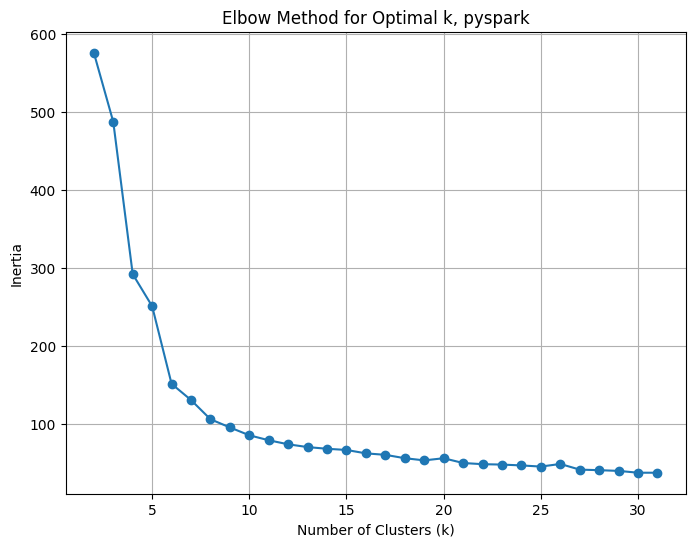

In [0]:
import matplotlib.pyplot as plt

# optimal seems to be 8
plt.figure(figsize=(8,6))
plt.plot(k_range, inertia_values_mlib, marker='o')
plt.title('Elbow Method for Optimal k, pyspark')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

## SKLEARN implementation

In [0]:
from sklearn.cluster import KMeans # ensuring sklearn

# Create the model function
def create_model(k, X):
    start_time = time.time()

    # Start MLflow logging
    with mlflow.start_run():
        mlflow.set_tag("model_name", "3sklearn-k:" + str(k))

        kmeans = KMeans(n_clusters=k, random_state=1)
        kmeans.fit(X)

        cluster_centers = kmeans.cluster_centers_
    
        min_dists = [euclidean_distance(point, cluster_centers) for point in X]

        mean_distance = np.mean(min_dists)
        stddev_distance = np.std(min_dists)

        z_scores = [(dist - mean_distance) / stddev_distance for dist in min_dists]

        num_anomalies =  sum(abs(z) > threshold for z in z_scores)
        anomaly_percentage = num_anomalies / len(z_scores) * 100

        end_time = time.time()

        mlflow.log_metric("threshold", threshold)
        mlflow.log_metric("k", k)
        mlflow.log_metric("num_anomalies", num_anomalies)
        mlflow.log_metric("anomalies_percentage", anomaly_percentage)
        mlflow.log_metric("time", (end_time - start_time))

        SKLEARN_times.append((end_time - start_time))
        SKLEARN_anomaly_percentage.append(anomaly_percentage)

        # return inertia
        return kmeans.inertia_


### Converting pyspark df to pandas ###
s_time = time.time()
pandas_df = scaled_df.select("scaled_features").toPandas()
X = np.array(pandas_df["scaled_features"].tolist())

e_time = time.time()
df_conversion_time = e_time - s_time
print(f"Time to convert pyspark df to pandas for SKLEARN model: {df_conversion_time}")

for k in k_range:
    inertia_values_sklearn.append(create_model(k, X))

Time to convert pyspark df to pandas for SKLEARN model: 3.6150007247924805


### Find elbow point

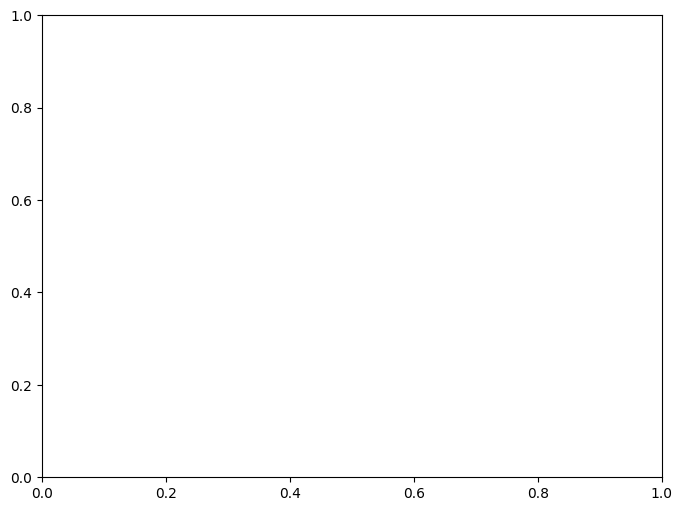

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
File <command-2249679042349211>, line 4
      2 # optimal seems to be 8
      3 plt.figure(figsize=(8,6))
----> 4 plt.plot(list(k_range), inertia_values_sklearn, marker='o')
      5 plt.title('Elbow Method for Optimal k')
      6 plt.xlabel('Number of Clusters (k)')

File /databricks/python/lib/python3.10/site-packages/matplotlib/pyplot.py:2769, in plot(scalex, scaley, data, *args, **kwargs)
   2767 @_copy_docstring_and_deprecators(Axes.plot)
   2768 def plot(*args, scalex=True, scaley=True, data=None, **kwargs):
-> 2769     return gca().plot(
   2770         *args, scalex=scalex, scaley=scaley,
   2771         **({"data": data} if data is not None else {}), **kwargs)

File /databricks/python/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1632, in Axes.plot(self, scalex, scaley, data, *args, **kwargs)
   1390 """
   1391 Plot y v

In [0]:
import matplotlib.pyplot as plt
# optimal seems to be 8
plt.figure(figsize=(8,6))
plt.plot(list(k_range), inertia_values_sklearn, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

## Performance comparison sklearn and pyspark

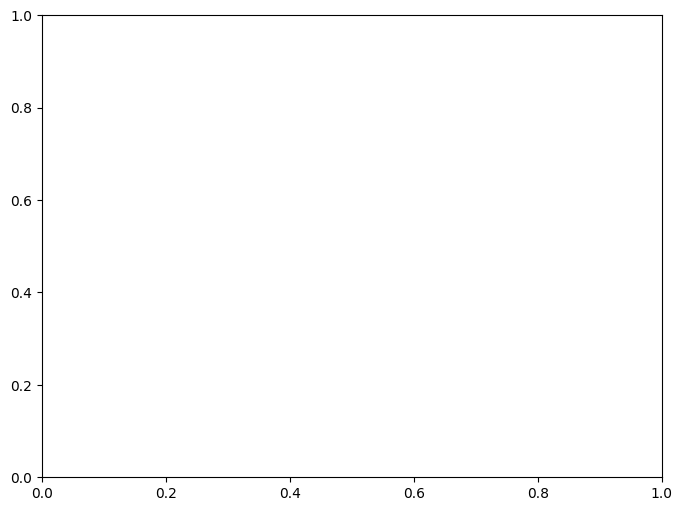

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
File <command-3501066346906956>, line 2
      1 plt.figure(figsize=(8,6))
----> 2 plt.plot(list(k_range), SKLEARN_anomaly_percentage, marker='o', label='sklearn', color='b')
      3 plt.plot(list(k_range), MLib_anomaly_percentage, marker='o', label = 'MLib', color='r')
      4 plt.title('SKLEARN v MLib')

File /databricks/python/lib/python3.10/site-packages/matplotlib/pyplot.py:2769, in plot(scalex, scaley, data, *args, **kwargs)
   2767 @_copy_docstring_and_deprecators(Axes.plot)
   2768 def plot(*args, scalex=True, scaley=True, data=None, **kwargs):
-> 2769     return gca().plot(
   2770         *args, scalex=scalex, scaley=scaley,
   2771         **({"data": data} if data is not None else {}), **kwargs)

File /databricks/python/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1632, in Axes.plot(self, scalex, scaley, data, *args,

In [0]:
plt.figure(figsize=(8,6))
plt.plot(list(k_range), SKLEARN_anomaly_percentage, marker='o', label='sklearn', color='b')
plt.plot(list(k_range), MLib_anomaly_percentage, marker='o', label = 'MLib', color='r')
plt.title('SKLEARN v MLib')
plt.xlabel('K')
plt.ylabel('Anomaly Percentage')
plt.grid(True)
plt.legend()
plt.show()


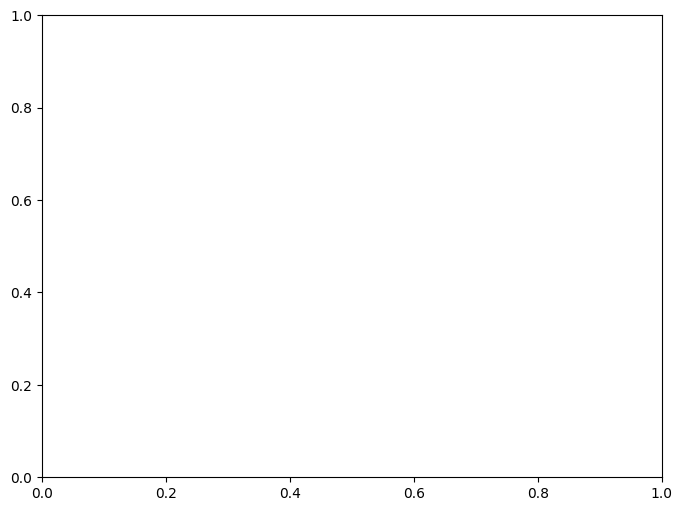

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
File <command-3501066346906961>, line 2
      1 plt.figure(figsize=(8,6))
----> 2 plt.plot(list(k_range), SKLEARN_times, marker='o', label='sklearn', color='b')
      3 plt.plot(list(k_range), MLib_times, marker='o', label='MLib' , color='r')
      4 plt.title('TIME')

File /databricks/python/lib/python3.10/site-packages/matplotlib/pyplot.py:2769, in plot(scalex, scaley, data, *args, **kwargs)
   2767 @_copy_docstring_and_deprecators(Axes.plot)
   2768 def plot(*args, scalex=True, scaley=True, data=None, **kwargs):
-> 2769     return gca().plot(
   2770         *args, scalex=scalex, scaley=scaley,
   2771         **({"data": data} if data is not None else {}), **kwargs)

File /databricks/python/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1632, in Axes.plot(self, scalex, scaley, data, *args, **kwargs)
   1390 """
   1391 Plot y

In [0]:
plt.figure(figsize=(8,6))
plt.plot(list(k_range), SKLEARN_times, marker='o', label='sklearn', color='b')
plt.plot(list(k_range), MLib_times, marker='o', label='MLib' , color='r')
plt.title('TIME')
plt.xlabel('K')
plt.ylabel('TIME')
plt.grid(True)
plt.legend()
plt.show()

I was running some code on the same cluster at the same time. Potentially, that is what made the one MLib instance take significantly longer. 

### Threshold -> anomaly percentage

Using SKLEARN with 25 cluster centers as it is a lot faster than Mlib

In [0]:
k = 26
pandas_df = scaled_df.select("scaled_features").toPandas()
X = np.array(pandas_df["scaled_features"].tolist())

SKLEARN_times = []
SKLEARN_anomaly_percentage = []

inertia_values_sklearn = []

thresholds = np.arange(1, 4.2, 0.2)
for t in thresholds:
  threshold = t
  inertia_values_sklearn.append(create_model(k, X))

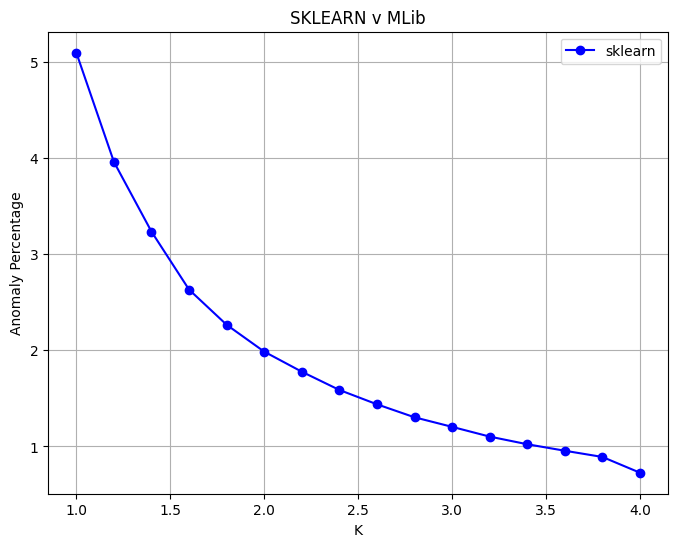

In [0]:
plt.figure(figsize=(8,6))
plt.plot(thresholds, SKLEARN_anomaly_percentage, marker='o', label='sklearn', color='b')
plt.title('SKLEARN v MLib')
plt.xlabel('K')
plt.ylabel('Anomaly Percentage')
plt.grid(True)
plt.legend()
plt.show()

## Model Evaluation

- Sklearn was faster than pyspark so sticking with that. 
- Choosing a model with k=25 based on the elbow point above. 
- Thershold = 1.05,, as it is about 5% of the data, which is the contaminatino rate I sat for the isolation forest and lof

In [0]:
pandas_df = scaled_df.select("scaled_features").toPandas()
X = np.array(pandas_df["scaled_features"].tolist())

threshold = 1.05
k = 25

Fitting the model and finding the anomalies

In [0]:
from sklearn.cluster import KMeans # ensuring sklearn

kmeans = KMeans(n_clusters=k, random_state=1)
kmeans.fit(X)

cluster_centers = kmeans.cluster_centers_
    
min_dists = [euclidean_distance(point, cluster_centers) for point in X]

mean_distance = np.mean(min_dists)
stddev_distance = np.std(min_dists)

z_scores = [(dist - mean_distance) / stddev_distance for dist in min_dists]

num_anomalies =  sum(abs(z) > threshold for z in z_scores)
anomaly_percentage = num_anomalies / len(z_scores) * 100


Creating two dataframes. One df_anomaly_scaled, which has the scaled data and the outliers (1, -1). And, one df_anomaly which has the unscaled data plus a column with the outliers (1, -1).

In [0]:
X_anomaly_scaled = np.insert(X, X.shape[1], z_scores, axis=1)

df_anomaly_scaled = pd.DataFrame(X_anomaly_scaled)

output_cols = input_cols
output_cols.append("outliers")
df_anomaly_scaled.columns = output_cols

df_anomaly_scaled.head()

trip_distance  fare_amount  ...  time_diff_minutes  outliers
0       0.016735     0.188571  ...           0.001934 -0.391253
1       0.016735     0.182857  ...           0.000718 -0.606084
2       0.016327     0.188571  ...           0.001864  2.182424
3       0.011020     0.177143  ...           0.000579 -0.374510
4       0.054694     0.211429  ...           0.003451  0.204991

[5 rows x 6 columns]

In [0]:
df_anomaly_scaled.loc[abs(df_anomaly_scaled["outliers"]) <= threshold, "outliers"] = 1
df_anomaly_scaled.loc[abs(df_anomaly_scaled["outliers"]) > threshold, "outliers"] = -1

df_anomaly_scaled.head()

trip_distance  fare_amount  ...  time_diff_minutes  outliers
0       0.016735     0.188571  ...           0.001934       1.0
1       0.016735     0.182857  ...           0.000718       1.0
2       0.016327     0.188571  ...           0.001864      -1.0
3       0.011020     0.177143  ...           0.000579       1.0
4       0.054694     0.211429  ...           0.003451       1.0

[5 rows x 6 columns]

In [0]:
df_unscaled = df.toPandas()
input_cols = ['trip_distance', 'fare_amount', 'tip_amount', 'congestion_surcharge', 'time_diff_minutes']
df_unscaled = df_unscaled[input_cols]

df_anomaly = pd.DataFrame(df_unscaled)
df_anomaly["outliers"] = z_scores
df_anomaly.head()

trip_distance  fare_amount  ...  time_diff_minutes  outliers
0           0.41          4.0  ...              2.783 -0.391253
1           0.41          3.5  ...              1.033 -0.606084
2           0.40          4.0  ...              2.683  2.182424
3           0.27          3.0  ...              0.833 -0.374510
4           1.34          6.0  ...              4.967  0.204991

[5 rows x 6 columns]

In [0]:
## Setting anomaly to -1, normal to 1

df_anomaly.loc[abs(df_anomaly["outliers"]) <= threshold, "outliers"] = 1
df_anomaly.loc[abs(df_anomaly["outliers"]) > threshold, "outliers"] = -1

df_anomaly.head()

trip_distance  fare_amount  ...  time_diff_minutes  outliers
0           0.41          4.0  ...              2.783       1.0
1           0.41          3.5  ...              1.033       1.0
2           0.40          4.0  ...              2.683      -1.0
3           0.27          3.0  ...              0.833       1.0
4           1.34          6.0  ...              4.967       1.0

[5 rows x 6 columns]

### Pair plot

In [0]:
print(f"Number of normal points: {sum(df_anomaly['outliers'] ==1)}")
print(f"Number of anomalies: {sum(df_anomaly['outliers'] ==-1)}")

print(f"Anomaly percentage: {round(anomaly_percentage, 2)}%")

Number of normal points: 95354
Number of anomalies: 5201
Anomaly percentage: 5.17%


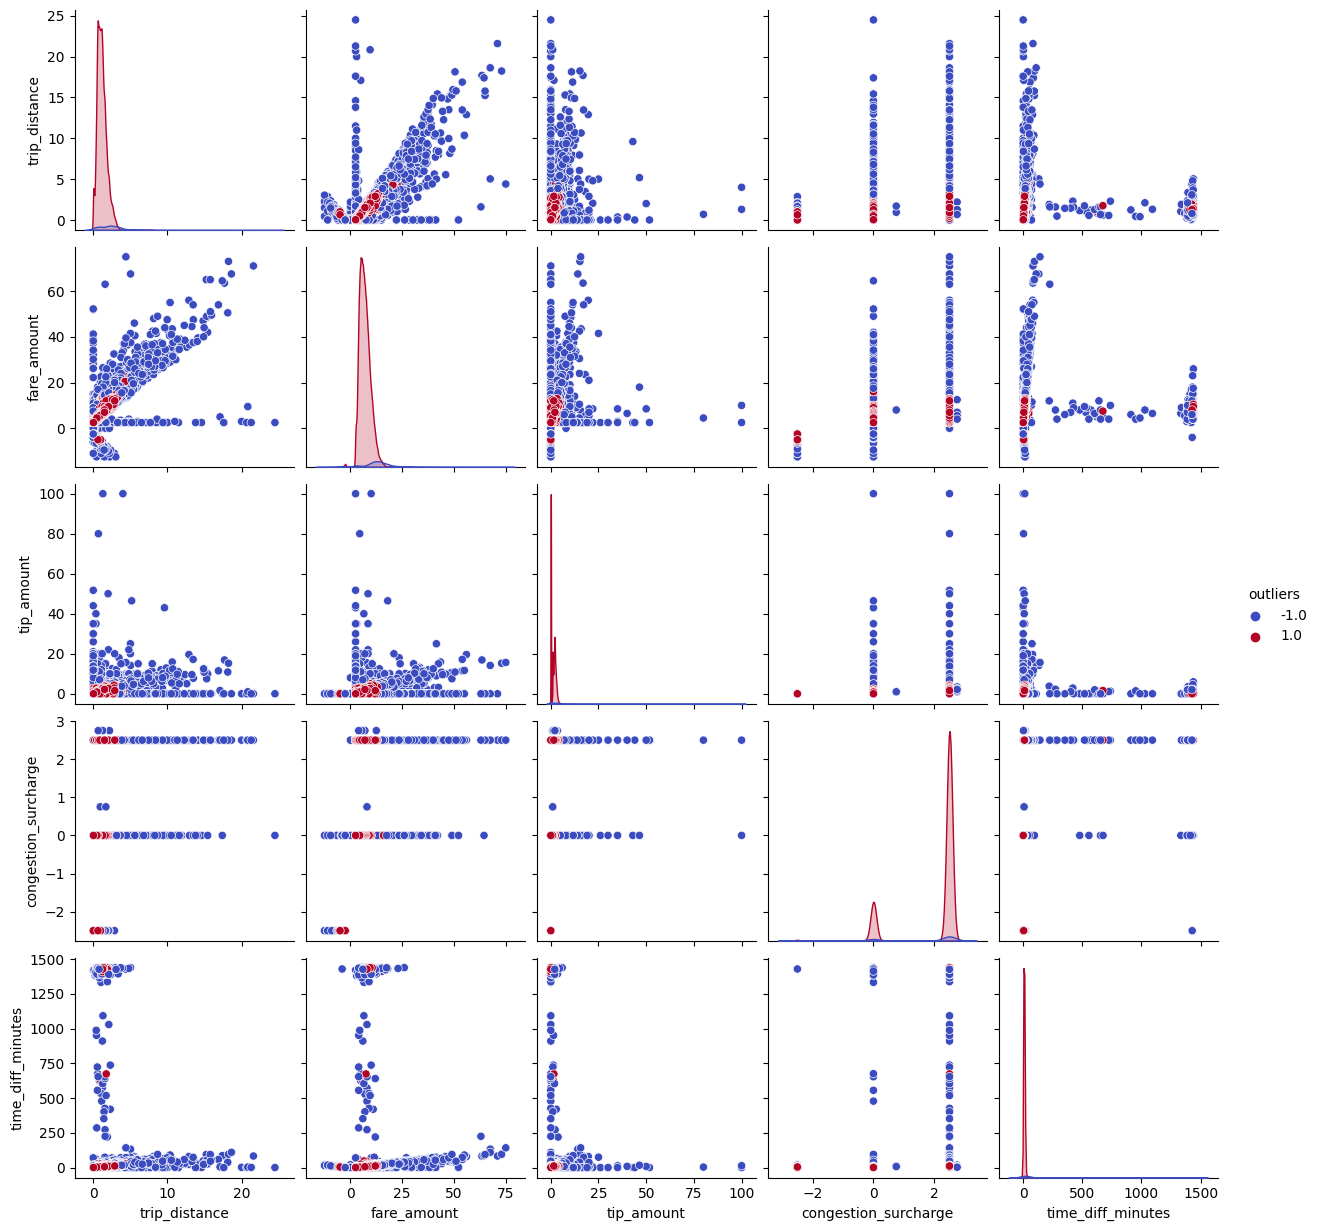

In [0]:
sns.pairplot(df_anomaly, hue="outliers", palette="coolwarm")
plt.show()

Just checking that the plots look the same for the scaled and unscaled data

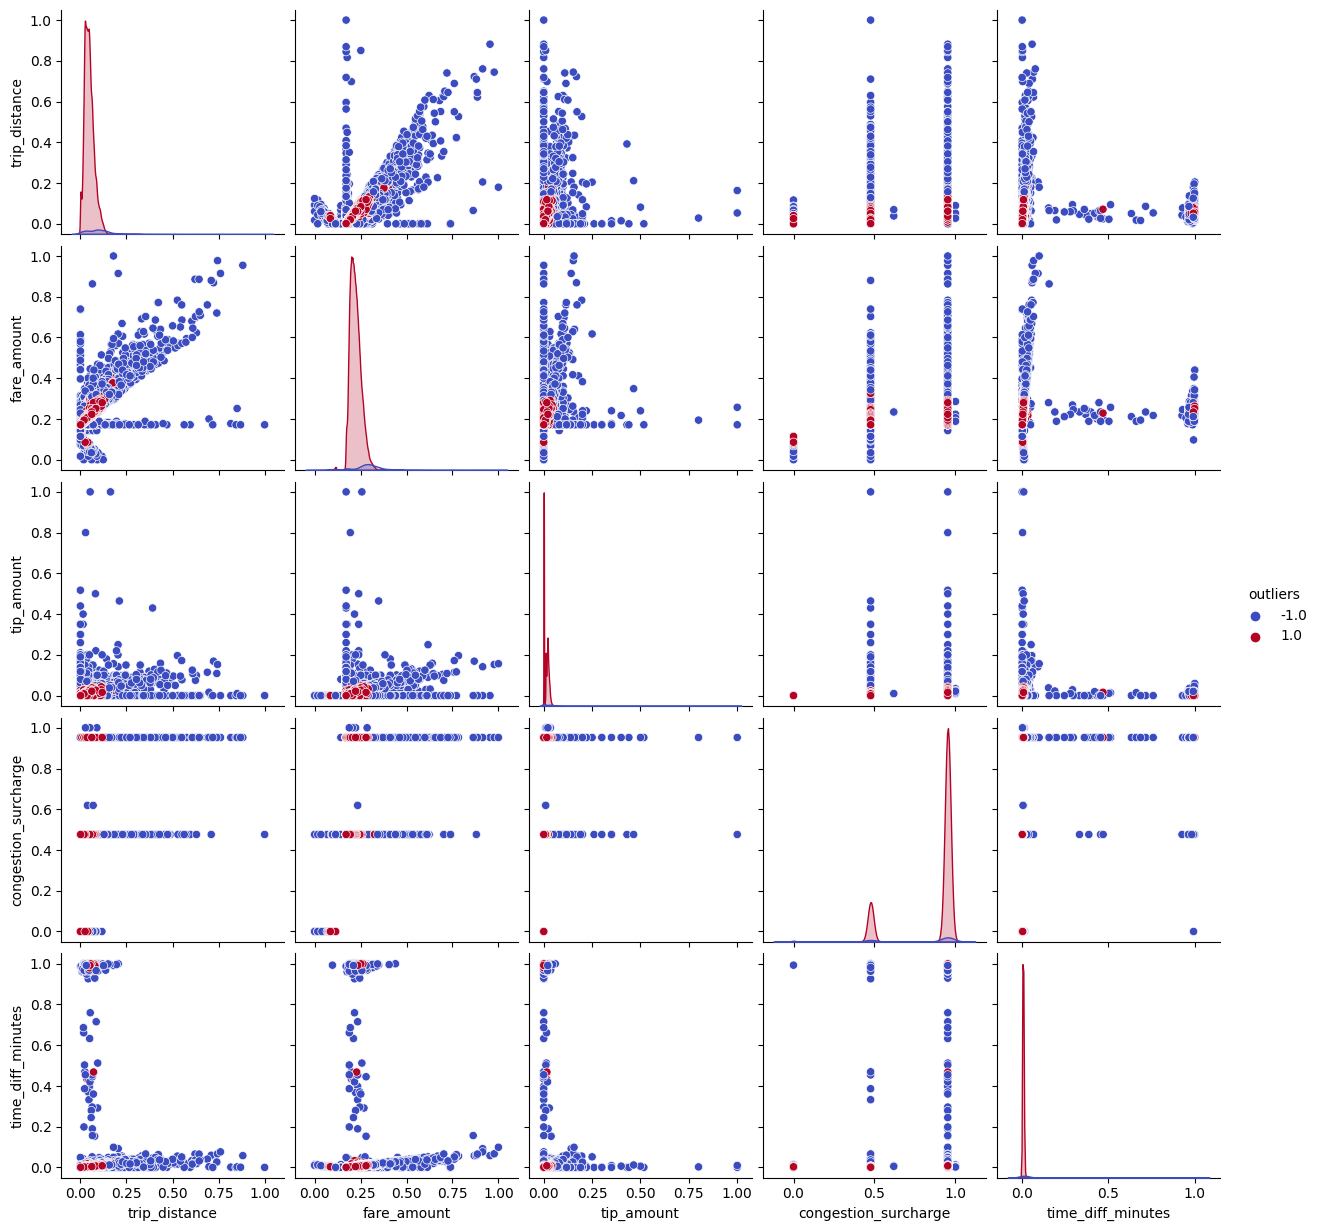

In [0]:
sns.pairplot(df_anomaly_scaled, hue="outliers", palette="coolwarm")
plt.show()

### Mean and variance 

In [0]:
df_anomaly_scaled.head()

trip_distance  fare_amount  ...  time_diff_minutes  outliers
0       0.016735     0.188571  ...           0.001934       1.0
1       0.016735     0.182857  ...           0.000718       1.0
2       0.016327     0.188571  ...           0.001864      -1.0
3       0.011020     0.177143  ...           0.000579       1.0
4       0.054694     0.211429  ...           0.003451       1.0

[5 rows x 6 columns]

In [0]:
X_scaled = df_anomaly_scaled.loc[df_anomaly_scaled["outliers"] == 1]
y_scaled = df_anomaly_scaled.loc[df_anomaly_scaled["outliers"] == -1]

In [0]:
normal_variance = X_scaled.var()
normal_mean = X_scaled.mean()

print(f"The mean of the normal points is: {normal_mean} \n The variance of the normal points is: {normal_variance}\n")

anomaly_variance = y_scaled.var()
anomaly_mean = y_scaled.mean()

print(f"The mean of the anomaly points is: {anomaly_mean} \n The variance of the anomaly points is: {anomaly_variance}")

The mean of the normal points is: trip_distance           0.046578
fare_amount             0.221113
tip_amount              0.012406
congestion_surcharge    0.874621
time_diff_minutes       0.005705
outliers                1.000000
dtype: float64 
 The variance of the normal points is: trip_distance           0.000662
fare_amount             0.000901
tip_amount              0.000123
congestion_surcharge    0.032533
time_diff_minutes       0.000764
outliers                0.000000
dtype: float64

The mean of the anomaly points is: trip_distance           0.103744
fare_amount             0.293207
tip_amount              0.024702
congestion_surcharge    0.810677
time_diff_minutes       0.039482
outliers               -1.000000
dtype: float64 
 The variance of the anomaly points is: trip_distance           0.007902
fare_amount             0.008335
tip_amount              0.001642
congestion_surcharge    0.051958
time_diff_minutes       0.024492
outliers                0.000000
dtype: float

In [0]:
import time
time.sleep(50000)

java.net.NoRouteToHostException: No route to host
	at java.base/sun.nio.ch.SocketChannelImpl.checkConnect(Native Method)
	at java.base/sun.nio.ch.SocketChannelImpl.finishConnect(SocketChannelImpl.java:777)
	at shaded.v9_4.org.eclipse.jetty.io.SelectorManager.doFinishConnect(SelectorManager.java:355)
	at shaded.v9_4.org.eclipse.jetty.io.ManagedSelector.processConnect(ManagedSelector.java:347)
	at shaded.v9_4.org.eclipse.jetty.io.ManagedSelector.access$1700(ManagedSelector.java:65)
	at shaded.v9_4.org.eclipse.jetty.io.ManagedSelector$SelectorProducer.processSelected(ManagedSelector.java:676)
	at shaded.v9_4.org.eclipse.jetty.io.ManagedSelector$SelectorProducer.produce(ManagedSelector.java:535)
	at shaded.v9_4.org.eclipse.jetty.util.thread.strategy.EatWhatYouKill.produceTask(EatWhatYouKill.java:362)
	at shaded.v9_4.org.eclipse.jetty.util.thread.strategy.EatWhatYouKill.doProduce(EatWhatYouKill.java:186)
	at shaded.v9_4.org.eclipse.jetty.util.thread.strategy.EatWhatYouKill.tryProduce(EatWhatYouKill.java:173)
	at shaded.v9_4.org.eclipse.jetty.util.thread.strategy.EatWhatYouKill.run(EatWhatYouKill.java:131)
	at shaded.v9_4.org.eclipse.jetty.util.thread.ReservedThreadExecutor$ReservedThread.run(ReservedThreadExecutor.java:409)
	at com.databricks.rpc.ShadedInstrumentedQueuedThreadPool$$anon$2.$anonfun$run$4(InstrumentedQueuedThreadPool.scala:183)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at com.databricks.logging.AttributionContextTracing.$anonfun$withAttributionContext$1(AttributionContextTracing.scala:48)
	at com.databricks.logging.AttributionContext$.$anonfun$withValue$1(AttributionContext.scala:271)
	at scala.util.DynamicVariable.withValue(DynamicVariable.scala:62)
	at com.databricks.logging.AttributionContext$.withValue(AttributionContext.scala:267)
	at com.databricks.logging.AttributionContextTracing.withAttributionContext(AttributionContextTracing.scala:46)
	at com.databricks.logging.AttributionContextTracing.withAttributionContext$(AttributionContextTracing.scala:43)
	at com.databricks.rpc.ShadedInstrumentedQueuedThreadPool.withAttributionContext(InstrumentedQueuedThreadPool.scala:130)
	at com.databricks.rpc.ShadedInstrumentedQueuedThreadPool$$anon$2.$anonfun$run$3(InstrumentedQueuedThreadPool.scala:183)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at com.databricks.instrumentation.QueuedThreadPoolInstrumenter.trackActiveThreads(QueuedThreadPoolInstrumenter.scala:126)
	at com.databricks.instrumentation.QueuedThreadPoolInstrumenter.trackActiveThreads$(QueuedThreadPoolInstrumenter.scala:123)
	at com.databricks.rpc.ShadedInstrumentedQueuedThreadPool.trackActiveThreads(InstrumentedQueuedThreadPool.scala:130)
	at com.databricks.rpc.ShadedInstrumentedQueuedThreadPool$$anon$2.run(InstrumentedQueuedThreadPool.scala:177)
	at shaded.v9_4.org.eclipse.jetty.util.thread.QueuedThreadPool.runJob(QueuedThreadPool.java:883)
	at shaded.v9_4.org.eclipse.jetty.util.thread.QueuedThreadPool$Runner.run(QueuedThreadPool.java:1034)
	at java.base/java.lang.Thread.run(Thread.java:829)